# Exercise 23: k-Means clustering and Gaussian mixture models

Today we'll implement k-means clustering and the Gaussian mixture model for density estimation.

## k-Means

First, let's implement k-means clustering.

We will first create a synthetic data set with samples $\mathbf{x}^{(i)} \in \mathbb{R}^n$.

Then we run the algorithm
- Randomly initialize $\mu_1, \ldots, \mu_k$
- Repeat until convergence:
  - For $i \in 1..m$, let $c^{(i)} \leftarrow \mathrm{argmin}_j \|\mu_j - \mathbf{x}^{(i)} \|.$
  - For $j \in 1..k$, let $$ \mu_j \leftarrow \frac{\sum_i \delta(c^{(i)} = j) \mathbf{x}^{(i)}}{\sum_i \delta(c^{(i)} = j)}$$
  
The cost function minimized by k-means is
$$J(\mu) = \sum_{i=1}^m \| x^{(i)} - \mu_{c^{(i)}} \|^2$$
  
First, create a dataset with 4 Gaussian clusters.

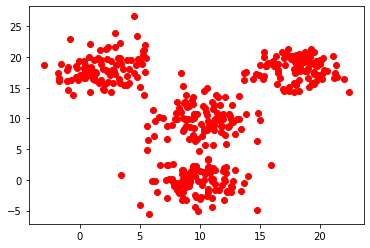

In [9]:
import numpy as np
import matplotlib.pyplot as plt

mu1_actual = np.array([10, 10])
mu2_actual = np.array([18, 18])
mu3_actual = np.array([10, 0])
mu4_actual = np.array([2, 18])
sigma = np.array([[4, 0], [0, 4]])

X1 = np.random.multivariate_normal(mu1_actual, sigma, 100)
X2 = np.random.multivariate_normal(mu2_actual, sigma, 100)
X3 = np.random.multivariate_normal(mu3_actual, sigma, 100)
X4 = np.random.multivariate_normal(mu4_actual, sigma, 100)

X = np.concatenate((X1, X2, X3, X4), 0)

plt.plot(X[:,0], X[:,1], 'ro')
plt.show()


In [10]:
def k_means(X, k):    
    # Randomly initialize mu's by choosing k elements from X without replacement
    m = X.shape[0]
    n = X.shape[1]
    indices = np.random.choice(np.arange(m), k, replace=False)
    Mu = X[indices,:]
    Cold = np.zeros(m)
    # Repeat until convergence
    while True:
        # C <- argmin_j |mu_j - x_i|
        distances = np.zeros((k, m))
        for j in range(k):
            distances[j,:] = ((Mu[j,:] - X) * (Mu[j,:] - X)).sum(axis=1).reshape(1, -1)
        C = np.argmin(distances, axis=0)
        J = np.min(distances, axis=0).mean()

        # mu_j = average of points closest to cluster j
        for j in range(k):
            Mu[j,:] = X[C==j,:].mean(axis=0)
        
        if (C == Cold).all():
            break

        Cold = np.copy(C)
    
    return Mu, J


Mu, J = k_means(X, 4)


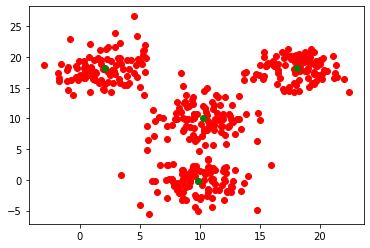

In [11]:

plt.plot(X[:,0], X[:,1], 'ro')
plt.plot(Mu[:,0], Mu[:,1], 'go')
plt.show()


Text(0, 0.5, 'J (average distortion)')

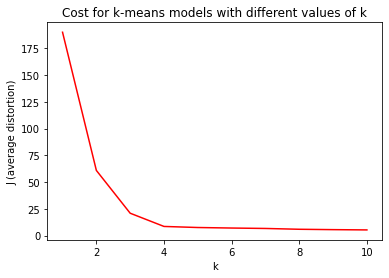

In [12]:
# Get cost of cluster assignments for different values of k

costs = []
for k in range(1,11):
    Mu, J = k_means(X, k)
    costs.append(J)
    
plt.plot(range(1,11), costs, 'r-')
plt.title('Cost for k-means models with different values of k')
plt.xlabel('k')
plt.ylabel('J (average distortion)')

We see an "elbow" at $k=4$.

## Gaussian mixture model

The GMM is similar to k-means except
- It performs a "soft" assignment of samples to clusters
- It models clusters of different sizes
- It models clusters of different shapes albeit Gaussian shaped

The algorithm looks like this:
- Randomly/arbitrarily initialize $\phi_1, \ldots, \mu_1, \ldots, \Sigma_1, \ldots$
- Repeat until convergence:
  - E-step:
    - For $i \in 1..m$, $j \in 1..k$,
      $$w^{(i)}_j \leftarrow p(z^{(i)} \mid \mathbf{x}^{(i)} ; \phi_1, \ldots, \mu_1, \ldots, \Sigma_1, \ldots)$$
  - M-step:
    - Update $\phi_1, \ldots$: $$\phi_j \leftarrow \frac{1}{m} \sum_{i=1}^m w_j^{(i)}$$
    - Update $\mu_1, \ldots$: $$\mu_j \leftarrow \frac{\sum_i w_j^{(i)} \mathbf{x}^{(i)}}{\sum_i w_j^{(i)}}$$
    - Update $\Sigma_1, \ldots$: $$\Sigma_j \leftarrow \frac{\sum_i w_j^{(i)} (\mathbf{x}^{(i)}-\mu_j)(\mathbf{x}^{(i)}-\mu_j)^T}{\sum_i w_j^{(i)}}$$
    
To test the method, we synthesize some data:

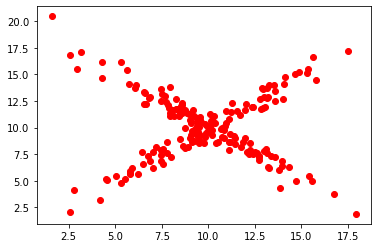

In [13]:
mu_actual = np.array([10, 10])
sigma_1 = np.array([[10, 9.8], [9.8, 10]])
sigma_2 = np.array([[10, -9.8], [-9.8, 10]])

X1 = np.random.multivariate_normal(mu_actual, sigma_1, 100)
X2 = np.random.multivariate_normal(mu_actual, sigma_2, 100)

X = np.concatenate((X1, X2), 0)

plt.plot(X[:,0], X[:,1], 'ro')
plt.show()


In [14]:
import scipy
import scipy.stats

def gmm(X, k):
    
    # Randomly initialize phi's, mu's, sigma's by choosing k elements from X without replacement

    m = X.shape[0]
    n = X.shape[1]
    indices = np.random.choice(np.arange(m), k, replace=False)
    Mu = X[indices,:]
    Sigma = []
    data_cov = X.T @ X / m
    for j in range(k):
        Sigma.append(data_cov.copy())
    Phi = np.ones(k) / k

    # Repeat until convergence
    
    wold = np.zeros((k, m))
    while True:
        
        # E-step: Calculate weight for each point in each cluster p(z^i = j | x^i)
        
        w = np.zeros((k, m))
        for j in range(k):
            w[j,:] = scipy.stats.multivariate_normal.pdf(X[:,:], mean=Mu[j,:], cov=Sigma[j]) * Phi[j]
        cost = - np.log(w.sum(axis=0)).mean()
        print('Cost:', cost)
        w = w / w.sum(axis=0)
            
        # M-step: Update parameters
        
        Phi = w.mean(axis=1)
        
        for j in range(k):
            Mu[j,:] = (w[j,:].reshape(m,1) * X).sum(axis=0) / w[j,:].sum()

        for j in range(k):
            Sigma[j] = (w[j:j+1,:].T * (X-Mu[j,:])).T @ (X - Mu[j,:]) / w[j,:].sum() 

        # Check for convergence
        
        if (w - wold <= 1e-6).all():
            break
    
        wold = w.copy()
        
    return Phi, Mu, Sigma


Phi, Mu, Sigma = gmm(X, 2)


Cost: 6.353212765028893
Cost: 5.092113516190394
Cost: 5.090013118585502
Cost: 5.086479979714076
Cost: 5.075957579341409
Cost: 5.0393726416678755
Cost: 4.931296472484232
Cost: 4.6985411311958485
Cost: 4.360814398938096
Cost: 4.154598207184663
Cost: 4.130467231468992
Cost: 4.129690171160228
Cost: 4.129668457391613
Cost: 4.1296675857442136
Cost: 4.129667532043323
Cost: 4.1296675277216055
Cost: 4.129667527334205
Cost: 4.129667527298231
Cost: 4.129667527294854
Cost: 4.1296675272945365


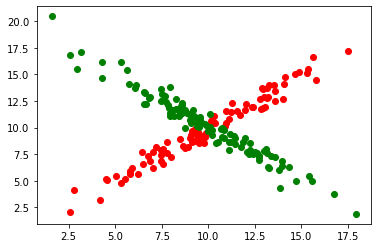

In [15]:
def gmm_assign(X, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = Mu.shape[0]
    w = np.zeros((k,m))
    for i in range(m):
        for j in range(k):
            w[j,i] = scipy.stats.multivariate_normal.pdf(X[i,:], mean=Mu[j,:], cov=Sigma[j]) * Phi[j]
    assignments = np.argmax(w, axis=0)
    return assignments

assignments = gmm_assign(X, Phi, Mu, Sigma)

plt.plot(X[assignments==0,0], X[assignments==0,1], 'ro')
plt.plot(X[assignments==1,0], X[assignments==1,1], 'go')
plt.show()